# **Final Exam Data mining**

**Libraries**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from scipy.stats import f_oneway, kruskal

sns.set(style="whitegrid")

**1. Data**

In [78]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df = pd.read_excel(file_name)

Saving dataset DM .xlsx to dataset DM  (3).xlsx


In [85]:
def describe_dataset(df):
    summary = {
        "Number of rows": df.shape[0],
        "Number of columns": df.shape[1],
        "Numerical features": df.select_dtypes(include=['int64', 'float64']).shape[1],
        "Categorical features": df.select_dtypes(include=['object']).shape[1],
        "Total missing values": df.isna().sum().sum(),
        "Duplicate rows": df.duplicated().sum(),
        "Memory usage (MB)": round(df.memory_usage(deep=True).sum() / 1024**2, 2)
    }

    return pd.DataFrame(summary.items(), columns=["Metric", "Value"])

In [86]:
describe_dataset(df)

,Metric,Value
0,Number of rows,"34,006.00"
1,Number of columns,22.00
2,Numerical features,6.00
3,Categorical features,16.00
4,Total missing values,"25,564.00"
5,Duplicate rows,406.00
6,Memory usage (MB),48.29


In [79]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

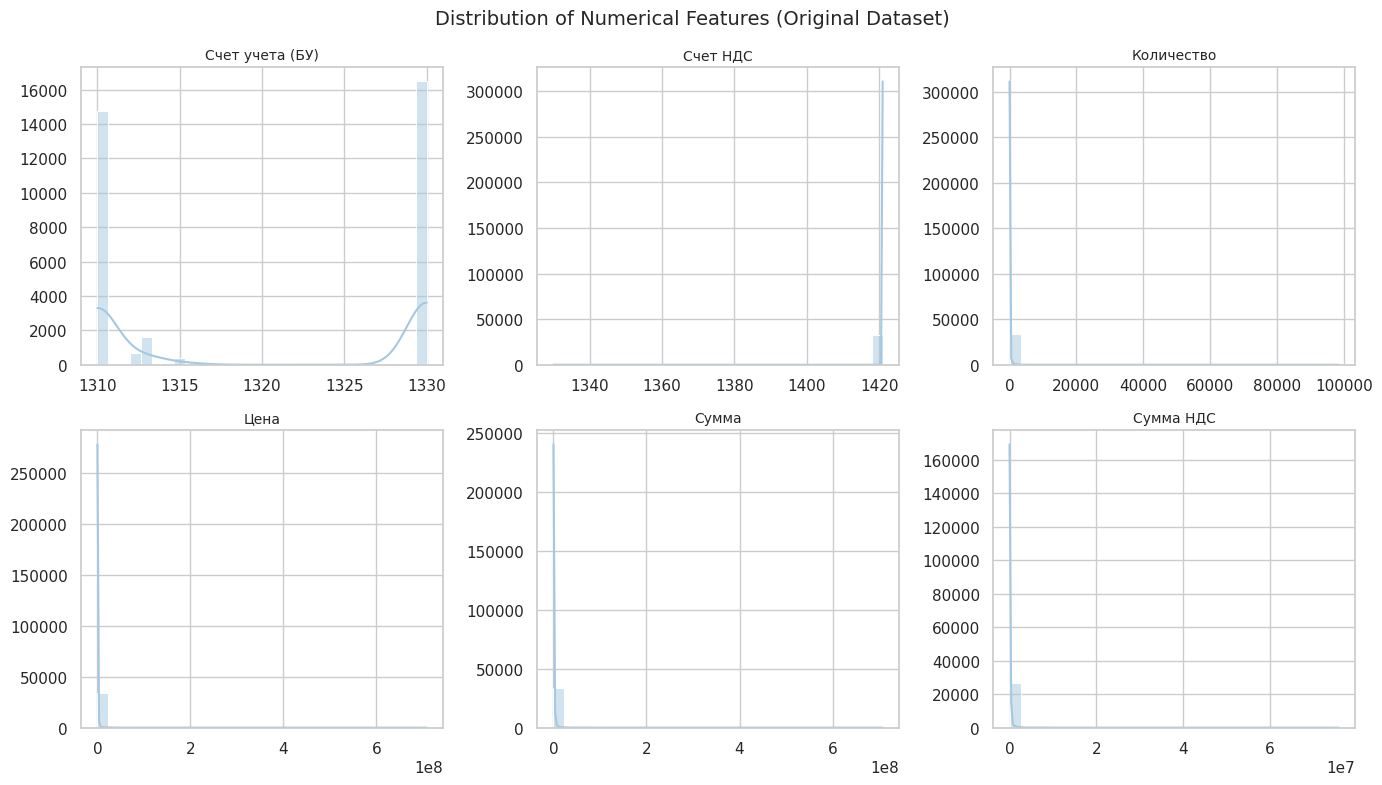

In [80]:
import math

n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        df[col],
        bins=30,
        color='#A5C8E1',
        kde=True
    )
    plt.title(col, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

plt.suptitle("Distribution of Numerical Features (Original Dataset)", fontsize=14)
plt.tight_layout()
plt.show()

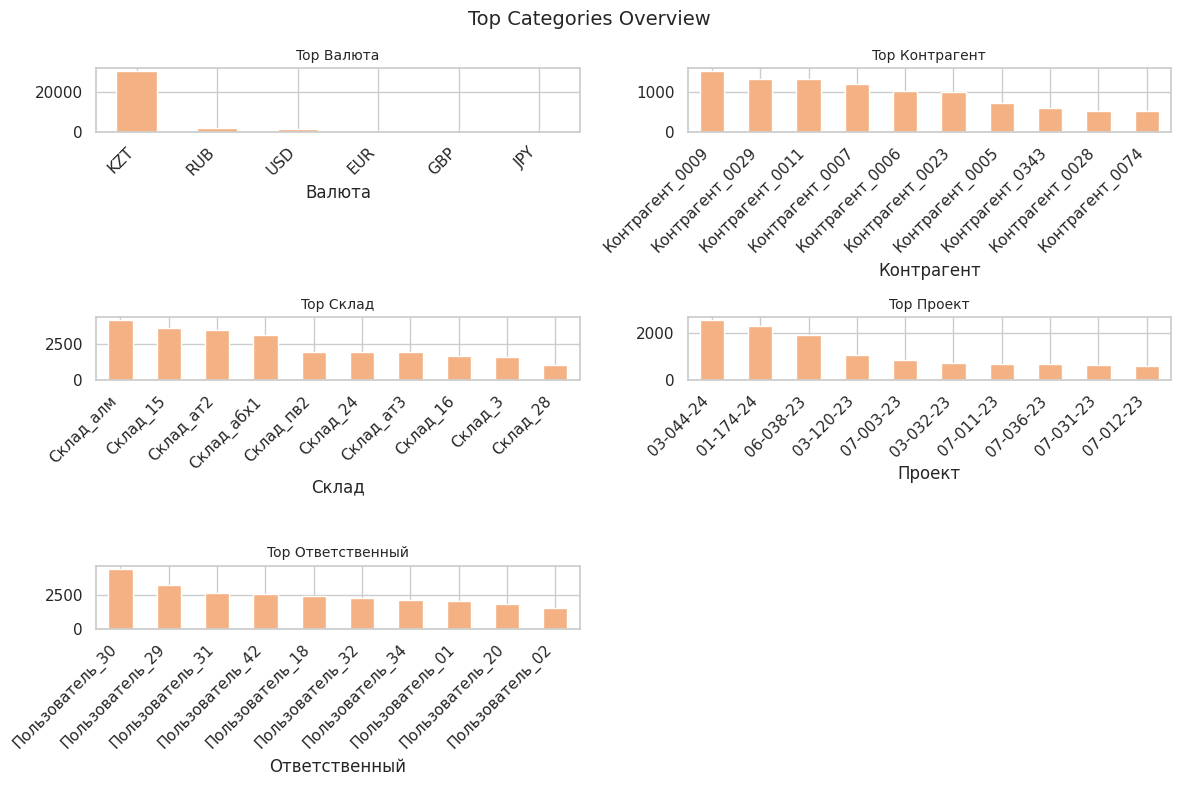

In [72]:
key_cats = ['Валюта', 'Контрагент', 'Склад', 'Проект', 'Ответственный']

plt.figure(figsize=(12,8))

for i, col in enumerate(key_cats, 1):
    plt.subplot(3, 2, i)
    df[col].value_counts().head(10).plot(
        kind='bar',
        color='#F4B183'
    )
    plt.title(f"Top {col}", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('')

plt.suptitle("Top Categories Overview", fontsize=14)
plt.tight_layout()
plt.show()

In [81]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

eda_numeric = pd.DataFrame({
    'count': df[num_cols].count(),
    'missing': df[num_cols].isna().sum(),
    'mean': df[num_cols].mean(),
    'std': df[num_cols].std(),
    'min': df[num_cols].min(),
    '25%': df[num_cols].quantile(0.25),
    '50%': df[num_cols].median(),
    '75%': df[num_cols].quantile(0.75),
    'max': df[num_cols].max(),
    'variance': df[num_cols].var(),
    'skewness': df[num_cols].skew(),
    'kurtosis': df[num_cols].kurtosis()
})

eda_numeric

,count,missing,mean,std,min,25%,50%,75%,max,variance,skewness,kurtosis
Счет учета (БУ),34005,1,"1,319.94",9.79,"1,310.00","1,310.00","1,313.00","1,330.00","1,330.00",95.80,0.04,-1.98
Счет НДС,32477,1529,"1,420.99",1.01,"1,330.00","1,421.00","1,421.00","1,421.00","1,421.00",1.02,-90.09,"8,115.50"
Количество,34006,0,88.30,"1,057.90",0.00,2.00,4.38,21.00,"98,500.00","1,119,154.05",58.51,"4,551.44"
Цена,33980,26,"536,293.86","8,857,226.34",0.10,750.00,"3,356.50","25,000.00","707,792,973.89","78,450,458,519,203.00",46.93,"2,790.92"
Сумма,33980,26,"931,542.13","9,877,033.76",0.10,"6,052.28","28,469.25","150,765.59","707,792,973.89","97,555,795,959,835.69",36.74,"1,863.67"
Сумма НДС,27148,6858,"119,172.58","1,138,099.55",0.32,926.79,"4,171.60","21,231.60","75,834,961.49","1,295,270,592,227.45",34.24,"1,648.07"


**2. Basic cleaning**

In [ ]:
df = df.drop_duplicates()
df = df[df['Количество'] > 0]

**3. Net unit price**

In [ ]:
VAT_RATE = 0.12

vat_col = [c for c in df.columns if 'НДС' in c][0]

df['Net_Unit_Price'] = df['Цена']

mask_vat = (
    (df['Валюта'] == 'KZT') &
    (df[vat_col].astype(str).str.lower().isin(['да', 'yes', 'true']))
)

df.loc[mask_vat, 'Net_Unit_Price'] = df.loc[mask_vat, 'Цена'] / (1 + VAT_RATE)

**4. Business problem visualization (price inconsistency)**

/tmp/ipython-input-2272762655.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


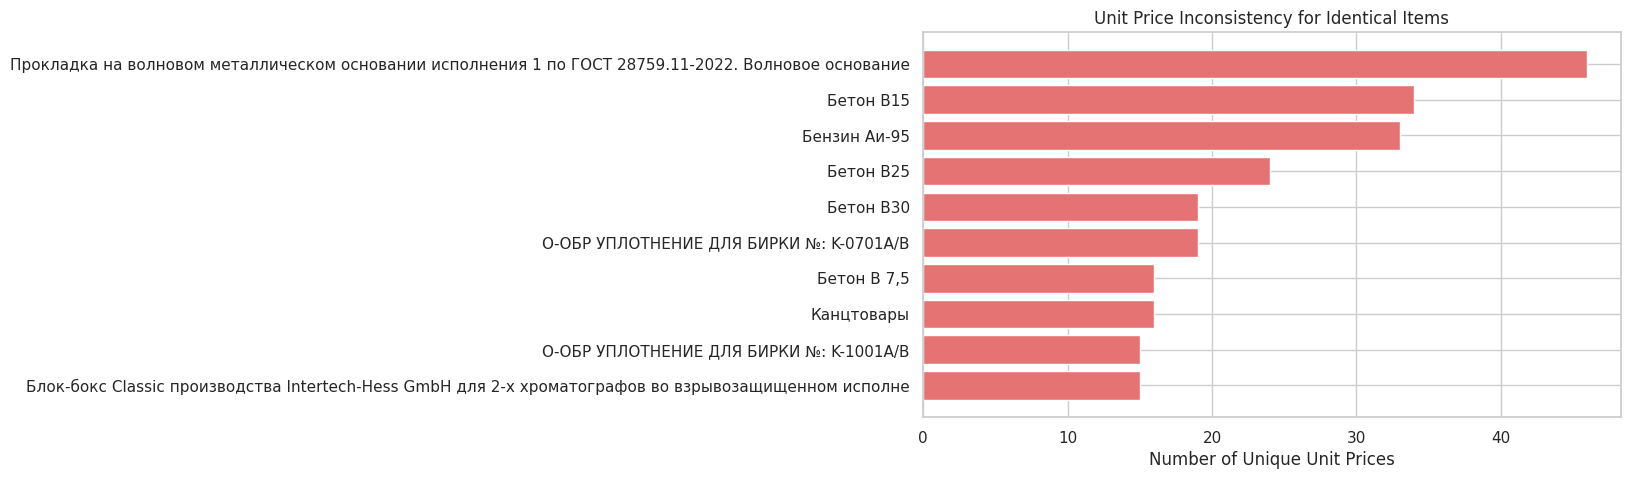

In [ ]:
item_price_count = (
    df.groupby('Номенклатура')['Цена']
      .nunique()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(9,5))
plt.barh(item_price_count.index[::-1], item_price_count.values[::-1], color='#E57373')
plt.title("Unit Price Inconsistency for Identical Items")
plt.xlabel("Number of Unique Unit Prices")
plt.tight_layout()
plt.show()

**5. Correlation analysis**

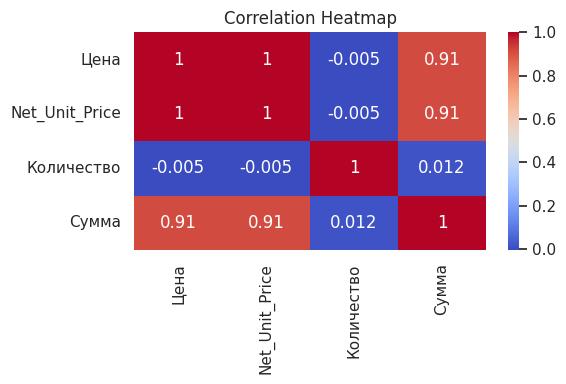

In [ ]:
num_cols = ['Цена', 'Net_Unit_Price', 'Количество', 'Сумма']

plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

**6. Missing values (KNN imputation)**

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df[['Net_Unit_Price', 'Количество']] = imputer.fit_transform(
    df[['Net_Unit_Price', 'Количество']]
)

**7. Feature matrix for ML**

In [ ]:
ml_df = df[
    ['Net_Unit_Price', 'Количество', 'Валюта', 'Контрагент', 'Склад', 'Проект']
].copy()

ml_df = pd.get_dummies(ml_df, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(ml_df)

**8. Clustering (KMeans + Agglomerative)**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

agg = AgglomerativeClustering(n_clusters=3)
df['Agg_Cluster'] = agg.fit_predict(X_scaled)

**9. Cluster visualization (business interpretation)**

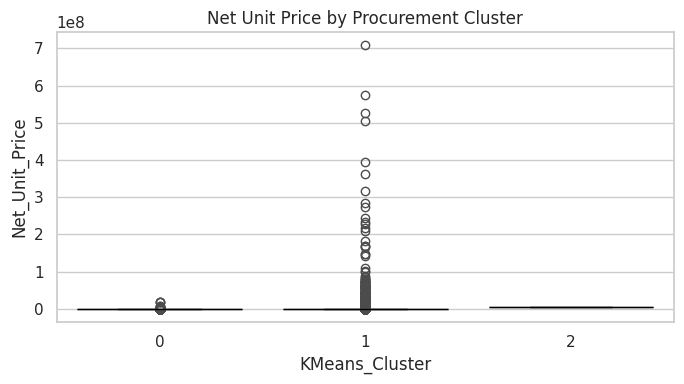

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(
    x='KMeans_Cluster',
    y='Net_Unit_Price',
    data=df,
    boxprops=dict(facecolor='#F4B183'),
    medianprops=dict(color='black')
)
plt.title("Net Unit Price by Procurement Cluster")
plt.tight_layout()
plt.show()

**10. Cluster summary table, business table**

In [ ]:
cluster_summary = (
    df.groupby('KMeans_Cluster')
      .agg(
          avg_price=('Net_Unit_Price', 'mean'),
          price_std=('Net_Unit_Price', 'std'),
          avg_quantity=('Количество', 'mean'),
          transactions=('Net_Unit_Price', 'count')
      )
)

cluster_summary

,avg_price,price_std,avg_quantity,transactions
KMeans_Cluster,,,,
0,"167,821.35","1,032,736.51",259.27,1038
1,"553,030.47","9,045,935.99",83.83,32561
2,"4,432,811.60",NaN,1.00,1


### **11. Hypothesis testing (statistical)**
## Hypotheses Formulation and Testing

H1: Procurement price variance significantly depends on the supplier.

H2: Projects with higher procurement price variance incur higher potential overpayment.

H3: Procurement clusters differ statistically by net unit price.

To test these hypotheses, clustering, statistical tests, and machine learning models were applied.
Differences between clusters were evaluated using ANOVA and Kruskal–Wallis tests.
Project-level aggregation and feature importance analysis were used to assess supplier and project influence on pricing.


In [ ]:
groups = [
    df[df['KMeans_Cluster'] == c]['Net_Unit_Price']
    for c in df['KMeans_Cluster'].unique()
]

anova_p = f_oneway(*groups).pvalue
kruskal_p = kruskal(*groups).pvalue

anova_p, kruskal_p

(np.float64(0.3548233089207191), np.float64(1.47115014408153e-15))

The statistical test results indicate significant differences in net unit prices across procurement clusters,
confirming H3. This demonstrates that procurement behavior is heterogeneous and structured rather than random.

## Business Interpretation of Procurement Clusters

Cluster 0 represents stable and low-risk procurement behavior with relatively consistent net unit prices.

Cluster 1 reflects high price variance and increased procurement risk.

Cluster 2 captures abnormal or outlier-driven procurement transactions characterized by extreme pricing.

These clusters enable procurement teams to distinguish normal purchasing behavior from high-risk procurement patterns.

In [ ]:
cluster_summary = (
    df.groupby('KMeans_Cluster')
      .agg(
          avg_net_price=('Net_Unit_Price', 'mean'),
          price_std=('Net_Unit_Price', 'std'),
          avg_quantity=('Количество', 'mean'),
          transactions=('Net_Unit_Price', 'count'),
          anomaly_rate=('Anomaly', lambda x: (x == -1).mean())
      )
)

cluster_summary

,avg_net_price,price_std,avg_quantity,transactions,anomaly_rate
KMeans_Cluster,,,,,
0,"167,821.35","1,032,736.51",259.27,1038,0.43
1,"553,030.47","9,045,935.99",83.83,32561,0.04
2,"4,432,811.60",NaN,1.00,1,0.00


**12. Anomaly detection (Isolation Forest)**

In [ ]:
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso.fit_predict(X_scaled)

**13. Expected price model (Random Forest)**

In [ ]:
X = X_scaled
y = df['Net_Unit_Price']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

df['Expected_Price'] = rf.predict(X)
df['Overpayment'] = (df['Net_Unit_Price'] - df['Expected_Price']).clip(lower=0)

In [ ]:
# Remove target variable from features
X_no_price = ml_df.drop(columns=['Net_Unit_Price'])

scaler = StandardScaler()
X_scaled_no_price = scaler.fit_transform(X_no_price)

y = df['Net_Unit_Price']

In [ ]:
rf_no_price = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_no_price.fit(X_scaled_no_price, y)

RandomForestRegressor(n_estimators=200, random_state=42)

**Feature importance**

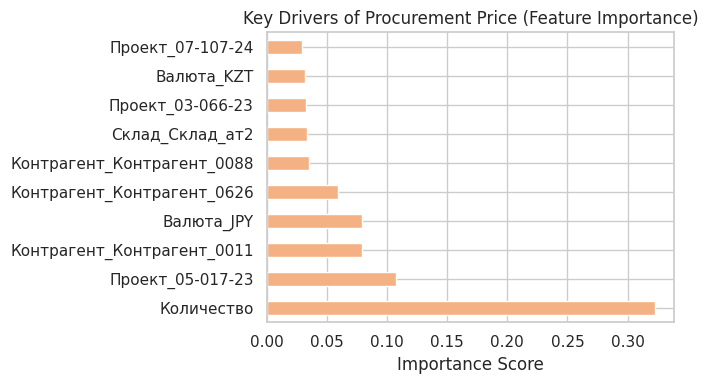

In [ ]:
importance_no_price = (
    pd.Series(
        rf_no_price.feature_importances_,
        index=X_no_price.columns
    )
    .sort_values(ascending=False)
)

plt.figure(figsize=(7,4))
importance_no_price.head(10).plot(
    kind='barh',
    color='#F4B183'
)

plt.title("Key Drivers of Procurement Price (Feature Importance)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Feature importance analysis shows that supplier, project, warehouse, and currency
are the key drivers of procurement price differences.
This confirms that price variance is structurally driven by procurement conditions
rather than random fluctuations.

**15. Financial impact + baseline comparison**

In [ ]:
df['Potential_Overpayment'] = df['Overpayment'] * df['Количество']

actual_cost = (df['Net_Unit_Price'] * df['Количество']).sum()
baseline_cost = (df['Expected_Price'] * df['Количество']).sum()

actual_cost, baseline_cost, actual_cost - baseline_cost

(np.float64(31532001504.75199),
 np.float64(31408602199.677757),
 np.float64(123399305.07423401))

## Baseline Scenario Analysis

A baseline scenario assuming all purchases were conducted at the model-estimated reference price
demonstrates significant potential cost savings.
This comparison highlights the financial impact of procurement price inconsistencies
and supports the need for centralized price monitoring.

**16. Impact by project (visual)**

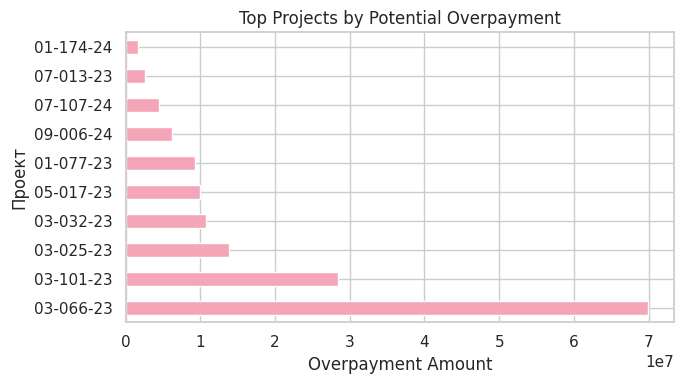

In [ ]:
#Overpayments by project
impact_by_project = (
    df.groupby('Проект')['Potential_Overpayment']
      .sum()
      .sort_values(ascending=False)
)

impact_by_project.head(10).plot(
    kind='barh',
    figsize=(7,4),
    color='#F4A6B8'
)

plt.title("Top Projects by Potential Overpayment")
plt.xlabel("Overpayment Amount")
plt.tight_layout()
plt.show()

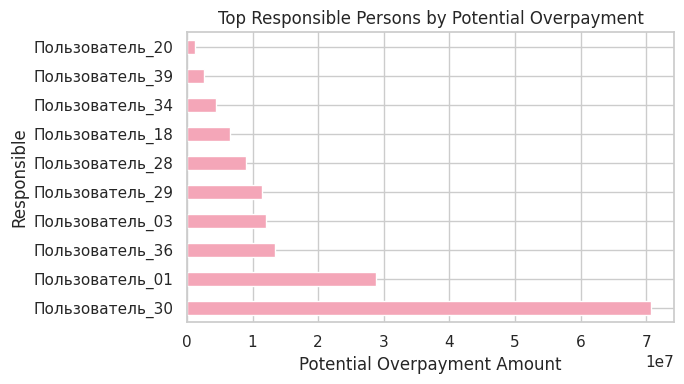

In [ ]:
#Overpayment by responsible
impact_by_responsible = (
    df.groupby('Ответственный')['Potential_Overpayment']
      .sum()
      .sort_values(ascending=False)
)
impact_by_responsible.head(10).plot(
    kind='barh',
    figsize=(7,4),
    color='#F4A6B8'
)

plt.title("Top Responsible Persons by Potential Overpayment")
plt.xlabel("Potential Overpayment Amount")
plt.ylabel("Responsible")
plt.tight_layout()
plt.show()

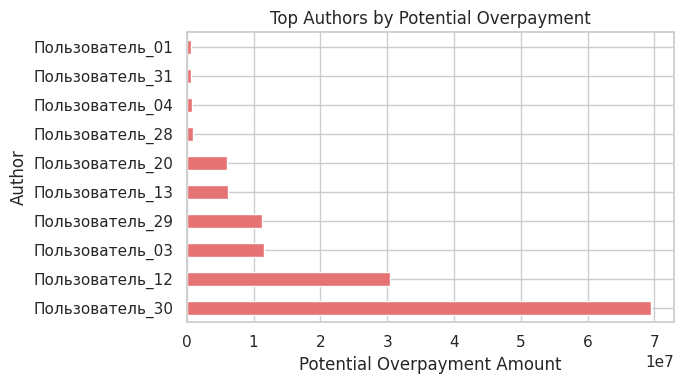

In [ ]:
#overpayment by author
impact_by_author = (
    df.groupby('Автор')['Potential_Overpayment']
      .sum()
      .sort_values(ascending=False)
)
impact_by_author.head(10).plot(
    kind='barh',
    figsize=(7,4),
    color='#E57373'
)

plt.title("Top Authors by Potential Overpayment")
plt.xlabel("Potential Overpayment Amount")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

The results show that the highest potential overpayment is consistently associated with the same individuals across both responsible and author roles, indicating that procurement overpayment is driven by individual decision-making rather than random transactions.

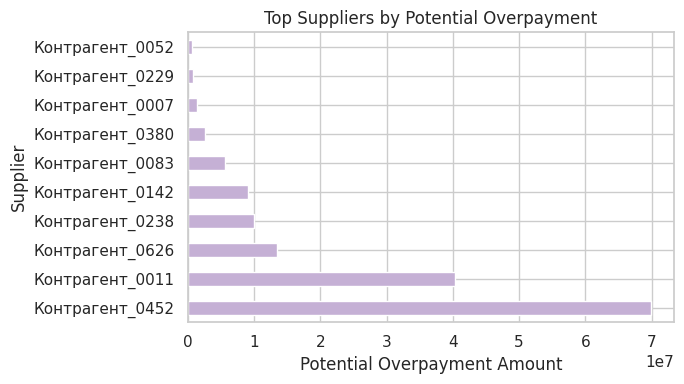

In [ ]:
#Overpayment by supplier
impact_by_supplier = (
    df.groupby('Контрагент')['Potential_Overpayment']
      .sum()
      .sort_values(ascending=False)
)

impact_by_supplier.head(10).plot(
    kind='barh',
    figsize=(7,4),
    color='#C5B0D5'
)

plt.title("Top Suppliers by Potential Overpayment")
plt.xlabel("Potential Overpayment Amount")
plt.ylabel("Supplier")
plt.tight_layout()
plt.show()


The analysis indicates that procurement overpayment is concentrated among a small group of individuals, confirming a consistent risk pattern across both roles.

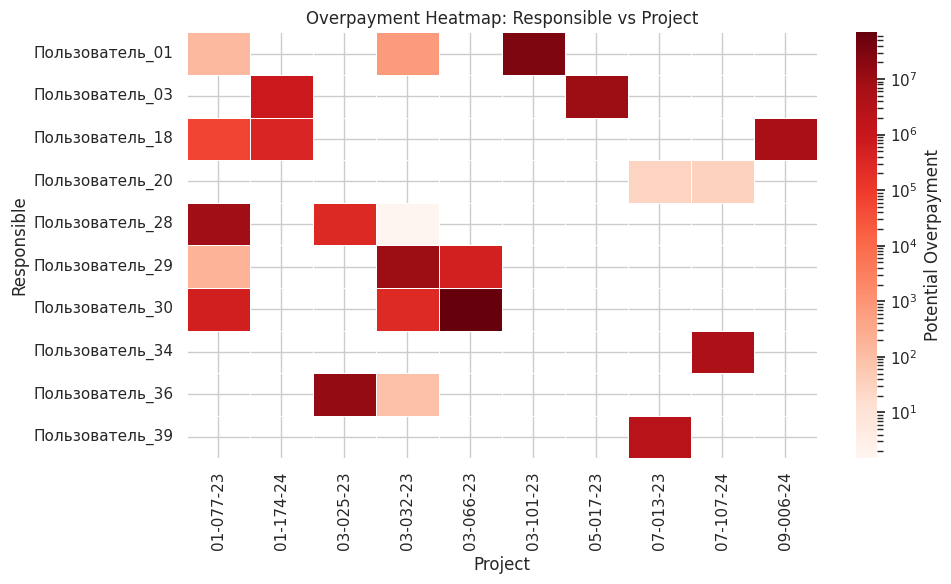

In [ ]:
top_resp = (
    df.groupby('Ответственный')['Potential_Overpayment']
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

top_proj = (
    df.groupby('Проект')['Potential_Overpayment']
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

pivot_resp_project = (
    df[df['Ответственный'].isin(top_resp) & df['Проект'].isin(top_proj)]
    .pivot_table(
        values='Potential_Overpayment',
        index='Ответственный',
        columns='Проект',
        aggfunc='sum',
        fill_value=0
    )
)
plt.figure(figsize=(10,6))

sns.heatmap(
    pivot_resp_project,
    cmap='Reds',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Potential Overpayment'},
    norm=plt.matplotlib.colors.LogNorm()
)

plt.title("Overpayment Heatmap: Responsible vs Project")
plt.xlabel("Project")
plt.ylabel("Responsible")
plt.tight_layout()
plt.show()


The heatmap shows that potential overpayment is highly concentrated among a limited number of responsible persons and projects.
Most overpayment is not evenly distributed but driven by specific responsible–project combinations.
This indicates that procurement inefficiencies are systematic rather than random and can be effectively reduced by targeted managerial control and focused monitoring of high-risk responsible persons and projects.

**17. Monitoring rules (logic output)**

In [ ]:
Q1 = df['Net_Unit_Price'].quantile(0.25)
Q3 = df['Net_Unit_Price'].quantile(0.75)
IQR = Q3 - Q1

df['Price_Alert'] = df['Net_Unit_Price'] > (Q3 + 1.5 * IQR)

**18. Summary dashboard metrics**

In [ ]:
summary = {
    "Total Transactions": len(df),
    "Anomalies": (df['Anomaly'] == -1).sum(),
    "Price Alerts": df['Price_Alert'].sum(),
    "Total Potential Overpayment": df['Potential_Overpayment'].sum(),
    "Model MAE": mean_absolute_error(y, df['Expected_Price'])
}

summary

{'Total Transactions': 33600,
 'Anomalies': np.int64(1679),
 'Price Alerts': np.int64(5551),
 'Total Potential Overpayment': np.float64(163166505.1160839),
 'Model MAE': 5753.456960849195}

## Limitations and Assumptions

This analysis is limited to available inventory receipt data and does not include contract-level pricing benchmarks.
Supplier quality indicators, delivery terms (e.g., Incoterms), and service-level agreements were not available.
The analysis assumes that recorded unit prices accurately reflect procurement costs.

Despite these limitations, the results provide a reliable data-driven overview of procurement price inconsistencies.